## 웹 로그 기반 조회수 예측 해커톤

### 데이터 구성

- sessionID : 세션 ID

- userID : 사용자 ID

- TARGET : 세션에서 발생한 총 조회수

- browser : 사용된 브라우저

- OS : 사용된 기기의 운영체제

- device : 사용된 기기

- new : 첫 방문 여부 (0: 첫 방문 아님, 1: 첫 방문)

- quality : 세션의 질 (거래 성사를 기준으로 측정된 값, 범위: 1~100)

- duration : 총 세션 시간 (단위: 초)

- bounced : 이탈 여부 (0: 이탈하지 않음, 1: 이탈함)

- transaction : 세션 내에서 발생의 거래의 수

- transaction_revenue : 총 거래 수익

- continent : 세션이 발생한 대륙

- subcontinent : 세션이 발생한 하위 대륙

- country : 세션이 발생한 국가

- traffic_source : 트래픽이 발생한 소스

- traffic_medium : 트래픽 소스의 매체

- keyword : 트래픽 소스의 키워드, 일반적으로 traffic_medium이 organic, cpc인 경우에 설정

- referral_path : traffic_medium이 referral인 경우 설정되는 경로

### 라이브러리 로드

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

### 데이터 로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# csv 파일 가져오기
df = pd.read_csv('/content/drive/MyDrive/dataset/open/train.csv')
df.head(5)

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
0,SESSION_000000,USER_000000,17.0,Chrome,Macintosh,desktop,0,45.0,839.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
1,SESSION_000001,USER_000001,3.0,Chrome,Windows,desktop,1,1.0,39.0,0,0.0,0.0,Europe,Western Europe,Germany,google,organic,Category8,NaN
2,SESSION_000002,USER_000002,1.0,Samsung Internet,Android,mobile,1,1.0,0.0,1,0.0,0.0,Asia,Southeast Asia,Malaysia,(direct),(none),NaN,NaN
3,SESSION_000003,USER_000003,1.0,Chrome,Macintosh,desktop,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,Partners,affiliate,NaN,NaN
4,SESSION_000004,USER_000004,1.0,Chrome,iOS,mobile,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,groups.google.com,referral,NaN,Category6_Path_0000


In [ ]:
df.shape

(252289, 19)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252289 entries, 0 to 252288
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   sessionID            252289 non-null  object 
 1   userID               252289 non-null  object 
 2   TARGET               252289 non-null  float64
 3   browser              252289 non-null  object 
 4   OS                   252289 non-null  object 
 5   device               252289 non-null  object 
 6   new                  252289 non-null  int64  
 7   quality              252289 non-null  float64
 8   duration             252289 non-null  float64
 9   bounced              252289 non-null  int64  
 10  transaction          252289 non-null  float64
 11  transaction_revenue  252289 non-null  float64
 12  continent            252289 non-null  object 
 13  subcontinent         252289 non-null  object 
 14  country              252289 non-null  object 
 15  traffic_source   

In [ ]:
# 세션ID의 수와 유저ID의 수 확인
unique_count1 = df['sessionID'].nunique()
print(unique_count1)
unique_count2 = df['userID'].nunique()
print(unique_count2)

252289
206024


In [ ]:
# 결측치 보기
df_null = df.isnull()
df_null.head()

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [ ]:
# 결측치 총 수 보기
df_null.sum()

sessionID                   0
userID                      0
TARGET                      0
browser                     0
OS                          0
device                      0
new                         0
quality                     0
duration                    0
bounced                     0
transaction                 0
transaction_revenue         0
continent                   0
subcontinent                0
country                     0
traffic_source              0
traffic_medium              0
keyword                137675
referral_path          161107
dtype: int64

* 값들이 object인데 결측치를 없애기엔 너무 많고, 어떻게 채울 것인가 생각해보기

In [ ]:
# 컬럼들의 값 종류 한눈에 확인하기
for i in df.columns[:]:
    if df[i].dtype == 'object':
        print(i,df[i].value_counts().index.values)

sessionID ['SESSION_000000' 'SESSION_168183' 'SESSION_168185' ... 'SESSION_084103'
 'SESSION_084104' 'SESSION_252288']
userID ['USER_002675' 'USER_000643' 'USER_002967' ... 'USER_074260' 'USER_074261'
 'USER_206023']
browser ['Chrome' 'Safari' 'Android Webview' 'Firefox' 'Internet Explorer' 'Edge'
 'Samsung Internet' 'Opera Mini' 'Safari (in-app)' 'Opera' 'UC Browser'
 'YaBrowser' 'Amazon Silk' 'Coc Coc' 'Mozilla Compatible Agent'
 'Android Browser' 'Puffin' 'MRCHROME' 'Nokia Browser' 'BlackBerry'
 'Maxthon' 'Playstation Vita Browser' 'Nintendo Browser' 'DESKTOP' 'Iron'
 'SeaMonkey' 'Konqueror' 'Browser' 'Mozilla' 'osee2unifiedRelease'
 '+Simple Browser' 'SAMSUNG-SM-B355E Opera' 'YE' 'Amazon.com'
 'Apple-iPhone7C2' 'Seznam' 'bsfnwveckhgpdoyjxmizruqtla'
 ';__CT_JOB_ID__:a80e8e16-6e98-455b-885a-a4dd40f3d344;'
 ';__CT_JOB_ID__:4333777f-bb0c-4a18-935e-df5658dbce2d;'
 ';__CT_JOB_ID__:2547db0b-ec43-452a-a0d4-ff42b7dc7907;'
 ';__CT_JOB_ID__:2e0eca60-83ab-482d-bb81-343d113254fb;'
 ';__CT_JOB_I

In [ ]:
col_1 = ['browser', 'OS', 'device', 'continent']
for i in col_1[:]:
    if df[i].dtype == 'object':
        print(i,df[i].value_counts().index.values)
        print()

browser ['Chrome' 'Safari' 'Android Webview' 'Firefox' 'Internet Explorer' 'Edge'
 'Samsung Internet' 'Opera Mini' 'Safari (in-app)' 'Opera' 'UC Browser'
 'YaBrowser' 'Amazon Silk' 'Coc Coc' 'Mozilla Compatible Agent'
 'Android Browser' 'Puffin' 'MRCHROME' 'Nokia Browser' 'BlackBerry'
 'Maxthon' 'Playstation Vita Browser' 'Nintendo Browser' 'DESKTOP' 'Iron'
 'SeaMonkey' 'Konqueror' 'Browser' 'Mozilla' 'osee2unifiedRelease'
 '+Simple Browser' 'SAMSUNG-SM-B355E Opera' 'YE' 'Amazon.com'
 'Apple-iPhone7C2' 'Seznam' 'bsfnwveckhgpdoyjxmizruqtla'
 ';__CT_JOB_ID__:a80e8e16-6e98-455b-885a-a4dd40f3d344;'
 ';__CT_JOB_ID__:4333777f-bb0c-4a18-935e-df5658dbce2d;'
 ';__CT_JOB_ID__:2547db0b-ec43-452a-a0d4-ff42b7dc7907;'
 ';__CT_JOB_ID__:2e0eca60-83ab-482d-bb81-343d113254fb;'
 ';__CT_JOB_ID__:a7ed0808-e70c-4b19-b1a3-1018bbb7dc7f;'
 ';__CT_JOB_ID__:85da5736-a78e-45a9-837e-f5a53e5cd725;'
 ';__CT_JOB_ID__:a24a8978-e5e8-4dc9-af66-c4ed89ea25d7;'
 ';__CT_JOB_ID__:89e59554-ad41-4e94-957b-f12bd012530c;' 'Netsc

In [ ]:
# 수치데이터에 대한 요약 보기
df.describe()

,TARGET,new,quality,duration,bounced,transaction,transaction_revenue
count,252289.000000,252289.000000,252289.000000,252289.000000,252289.000000,252289.000000,2.522890e+05
mean,3.592626,0.751955,3.816805,113.104253,0.493672,0.009033,9.061248e+05
std,5.509465,0.431879,11.091028,330.876019,0.499961,0.100938,2.127689e+07
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000e+00
75%,4.000000,1.000000,1.000000,71.000000,1.000000,0.000000,0.000000e+00
max,386.000000,1.000000,98.000000,11186.000000,1.000000,12.000000,3.325712e+09


In [ ]:
# 0인 개수 확인해보기
# duration : 총 세션 시간 (단위: 초)
# transaction : 세션 내에서 발생의? 발생한? 거래의 수
col_2  = ['duration','transaction']
df_2 = df
df_null = df_2[col_2].replace(0, np.nan)
df_null = df_null.isnull()
df_null.sum()

duration       124906
transaction    250081
dtype: int64

In [ ]:
df_null.mean() * 100

duration       49.509095
transaction    99.124813
dtype: float64

* 세션 내에서 발생한 거래의 수는 1퍼 미만?

In [ ]:
# 정답값인 TARGET의 개수 확인
df["TARGET"].value_counts()

1.0      126008
2.0       33690
3.0       23636
4.0       14291
5.0       10743
          ...  
125.0         1
171.0         1
270.0         1
81.0          1
199.0         1
Name: TARGET, Length: 117, dtype: int64

<Axes: xlabel='TARGET', ylabel='count'>

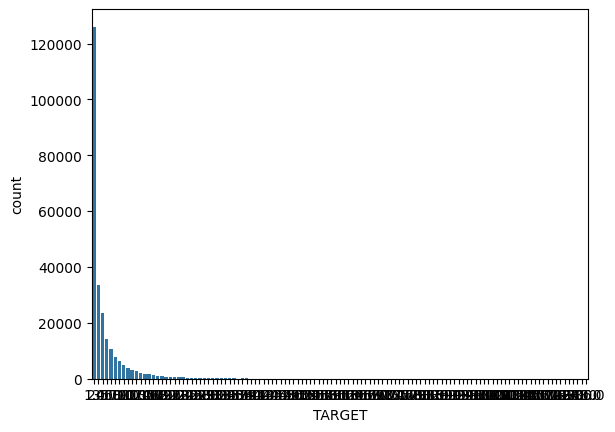

In [ ]:
# TARGET의 분포
sns.countplot(data=df, x="TARGET")

<Axes: ylabel='TARGET'>

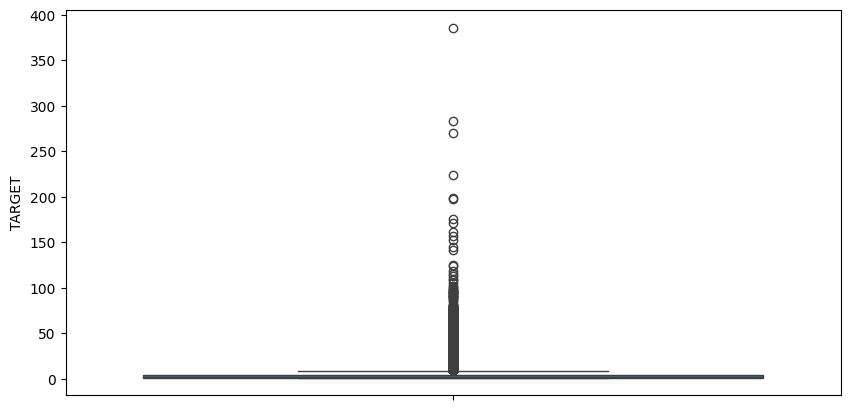

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(df["TARGET"])

<Axes: xlabel='quality', ylabel='count'>

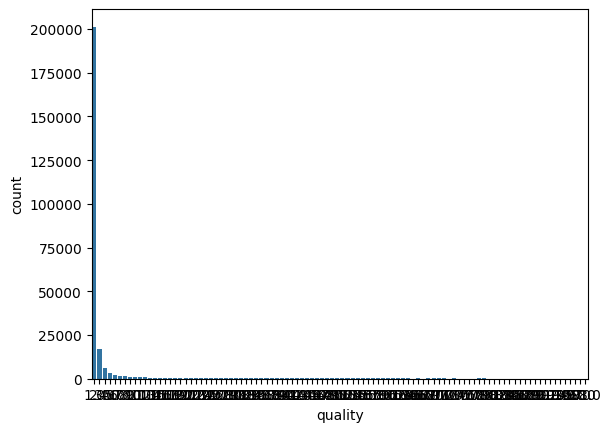

In [ ]:
sns.countplot(data=df, x="quality")

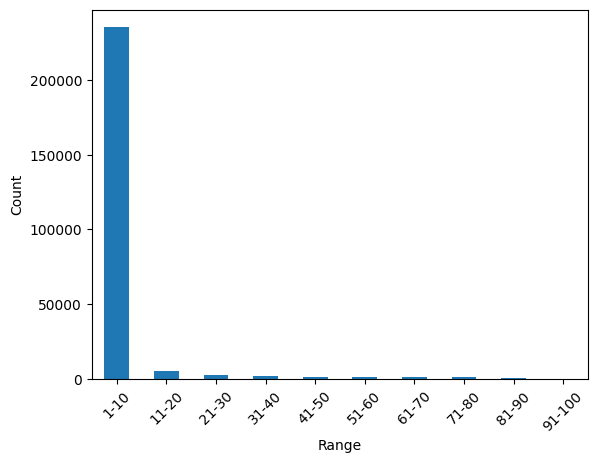

In [ ]:
# quality를 구간나누고 분포 확인
bins = range(0, 101, 10)
labels = [f"{i+1}-{i+10}" for i in bins[:-1]]
df['quality_group'] = pd.cut(df['quality'], bins=bins, labels=labels, right=False)

# 각 구간별 데이터 수를 계산
range_counts = df['quality_group'].value_counts().sort_index()

# 시각화
range_counts.plot(kind='bar')
plt.ylabel('Count')
plt.xlabel('Range')
plt.xticks(rotation=45)
plt.show()

* 1- 10 사이에 거의 대부분이 분포

In [ ]:
# 1-10 과 나머지 구간으로 범위 나눠보기
df["quality_less"] = df["quality"] <= 10
df["quality_high"] = df["quality"] > 10

In [ ]:
# 상관계수 구하기
df_corr = df.corr()
df_corr.style.background_gradient()

,TARGET,new,quality,duration,bounced,transaction,transaction_revenue,quality_less,quality_high
TARGET,1.000000,-0.066609,0.632723,0.595340,-0.464659,0.322097,0.180687,-0.614031,0.614031
new,-0.066609,1.000000,-0.182483,-0.087505,0.053208,-0.072169,-0.042463,0.153567,-0.153567
quality,0.632723,-0.182483,1.000000,0.459374,-0.249452,0.475446,0.246404,-0.835431,0.835431
duration,0.595340,-0.087505,0.459374,1.000000,-0.337534,0.211381,0.123186,-0.442235,0.442235
bounced,-0.464659,0.053208,-0.249452,-0.337534,1.000000,-0.088368,-0.042052,0.259729,-0.259729
transaction,0.322097,-0.072169,0.475446,0.211381,-0.088368,1.000000,0.462039,-0.331453,0.331453
transaction_revenue,0.180687,-0.042463,0.246404,0.123186,-0.042052,0.462039,1.000000,-0.159730,0.159730
quality_less,-0.614031,0.153567,-0.835431,-0.442235,0.259729,-0.331453,-0.159730,1.000000,-1.000000
quality_high,0.614031,-0.153567,0.835431,0.442235,-0.259729,0.331453,0.159730,-1.000000,1.000000


* quality_high와 TARGET의 상관계수와 quality와 TARGET의 상관계수가 비슷